In [2]:
import gymnasium
import highway_env
from matplotlib import pyplot as plt
%matplotlib inline


In [ ]:
from frozendict import frozendict
import numpy as np
import math
import copy

def to_hashable_state(info):
    vehicles = copy.deepcopy(info['vehicles'])
    for v in vehicles:
        v['position'] = tuple(float(i) for i in np.round(v['position'], 2))
        v['heading'] = float(np.round(v['heading'], 1))
        v["speed"] = float(np.round(v["speed"], 1))
    vehicles = tuple(frozendict(v) for v in vehicles)
    return vehicles

def set_vehicles(vehicles, env):
    for v, new_v in zip(env.unwrapped.road.vehicles, vehicles):
        assert id(v) == new_v['id']
        v.position = np.array(new_v['position'])
        v.heading = new_v['heading']
        v.speed = new_v['speed']

def make_mdp(*args, **kwargs):
    env = gymnasium.make(*args, **kwargs)
    _, info = env.reset()
    initial_state = to_hashable_state(info)
    action_dict = env.unwrapped.action_type.actions_indexes
    def step(state, action):
        set_vehicles(state, env)
        _, reward, done, _, info = env.step(action_dict[action])
        next_state = to_hashable_state(info)
        return next_state, reward, done
    return initial_state, step, list(action_dict.keys())


In [4]:
initial_state, step, actions = make_mdp("highway-v0")

In [ ]:
max_depth = 2

visited = set()
transitions = {}
frontier = {(initial_state, 0)}
while frontier:
    print(len(frontier), len(visited), len(transitions))
    state, depth = frontier.pop()
    visited.add(state)
    if depth < max_depth:
        for action in actions:
            if (state[0], action) not in transitions:
                transitions[(state[0], action)] = {}
            next_state, _, _ = step(state, action)
            if next_state[0] not in transitions[(state[0], action)]:
                transitions[(state[0], action)][next_state[0]] = 0
            transitions[(state[0], action)][next_state[0]] += 1
            if next_state not in visited:
                frontier.add((next_state, depth + 1))


1 0 0
5 1 5
9 2 10
8 3 10
12 4 15
11 5 15
15 6 20
14 7 20
13 8 20
12 9 20
11 10 20
14 11 20
13 12 20
12 13 20
11 14 20
10 15 20
9 16 20
8 17 20
12 18 20
11 19 20
10 20 20
9 21 20
8 22 20
7 23 20
6 24 20
5 25 20
4 26 20
3 27 20
2 28 20
1 29 20
 

         22087113 function calls (22063083 primitive calls) in 12.154 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1561169    3.060    0.000    3.346    0.000 lane.py:209(local_coordinates)
  1330360    1.328    0.000    1.457    0.000 lane.py:80(on_lane)
    26606    1.033    0.000    6.034    0.000 road.py:480(neighbour_vehicles)
   575280    0.897    0.000    1.457    0.000 _linalg.py:2575(norm)
   573750    0.820    0.000    2.429    0.000 objects.py:133(_is_colliding)
1497527/1496327    0.293    0.000    0.696    0.000 {built-in method builtins.isinstance}
  3153582    0.289    0.000    0.289    0.000 multiarray.py:761(dot)
   575280    0.276    0.000    0.276    0.000 {method 'dot' of 'numpy.ndarray' objects}
   573750    0.255    0.000    2.684    0.000 objects.py:94(handle_collisions)
   168972    0.242    0.000    0.242    0.000 _methods.py:99(_clip)
  1403289    0.231    0.000    0.394    0.000 <frozen abc>:1

In [85]:
for (s, a), ns_count in transitions.items():
    print(
        (s['position'], s['speed']),
        a[:6],
        [((ns['position'], ns['speed'])) for ns, count in ns_count.items()], sep='\t')

((180.98, 8.0), 25.0)	LANE_L	[((205.72, 4.59), 25.0)]
((180.98, 8.0), 25.0)	IDLE	[((205.72, 4.59), 25.0)]
((180.98, 8.0), 25.0)	LANE_R	[((205.98, 8.0), 25.0)]
((180.98, 8.0), 25.0)	FASTER	[((208.49, 8.0), 29.1)]
((180.98, 8.0), 25.0)	SLOWER	[((203.47, 8.0), 20.9)]
((208.49, 8.0), 29.1)	LANE_L	[((232.77, 4.67), 21.6)]
((208.49, 8.0), 29.1)	IDLE	[((232.77, 4.67), 21.6)]
((208.49, 8.0), 29.1)	LANE_R	[((233.02, 8.0), 21.6)]
((208.49, 8.0), 29.1)	FASTER	[((238.04, 8.0), 29.8)]
((208.49, 8.0), 29.1)	SLOWER	[((235.53, 8.0), 25.7)]
((205.98, 8.0), 25.0)	LANE_L	[((230.72, 4.59), 25.0)]
((205.98, 8.0), 25.0)	IDLE	[((230.72, 4.59), 25.0)]
((205.98, 8.0), 25.0)	LANE_R	[((230.98, 8.0), 25.0)]
((205.98, 8.0), 25.0)	FASTER	[((233.49, 8.0), 29.1)]
((205.98, 8.0), 25.0)	SLOWER	[((228.47, 8.0), 20.9)]
((203.47, 8.0), 20.9)	LANE_L	[((223.6, 4.62), 20.2)]
((203.47, 8.0), 20.9)	IDLE	[((223.6, 4.62), 20.2)]
((203.47, 8.0), 20.9)	LANE_R	[((223.92, 8.0), 20.2)]
((203.47, 8.0), 20.9)	FASTER	[((226.43, 8.0), 24

In [45]:
env = gymnasium.make(
    'highway-fast-v0',
)
env.reset()
# for _ in range(3):
#     action = env.unwrapped.action_type.actions_indexes["IDLE"]
#     obs, reward, done, truncated, info = env.step(action)
    # env.render()

# plt.imshow(env.render())
# plt.show()

(array([[ 1.        ,  0.75476736,  0.6666667 ,  0.3125    ,  0.        ],
        [ 1.        ,  0.10830408,  0.        , -0.02719155,  0.        ],
        [ 1.        ,  0.22787315, -0.33333334, -0.02301716,  0.        ],
        [ 1.        ,  0.35462636, -0.6666667 , -0.0333331 ,  0.        ],
        [ 1.        ,  0.4759117 , -0.6666667 , -0.0389575 ,  0.        ]],
       dtype=float32),
 {'speed': 25,
  'crashed': False,
  'action': np.int64(4),
  'vehicles': ({'id': 5598747472,
    'position': array([150.95347163,   8.        ]),
    'heading': np.float64(0.0),
    'speed': 25},
   {'id': 5667351568,
    'position': array([172.61428814,   8.        ]),
    'heading': np.float64(0.0),
    'speed': 22.82467612037394},
   {'id': 5661547472,
    'position': array([196.52810101,   4.        ]),
    'heading': np.float64(0.0),
    'speed': 23.15862749961896},
   {'id': 5667464144,
    'position': array([221.87874535,   0.        ]),
    'heading': np.float64(0.0),
    'speed': 22.3

In [ ]:
vehicles = to_hashable_state(info)


env.unwrapped.road.vehicles

[MDPVehicle #544: [230   0],
 IDMVehicle #968: [230   0],
 IDMVehicle #952: [260   0],
 IDMVehicle #968: [270  10],
 IDMVehicle #688: [300   0],
 IDMVehicle #632: [320  10],
 IDMVehicle #248: [340   0],
 IDMVehicle #712: [370   0],
 IDMVehicle #312: [390   0],
 IDMVehicle #376: [420   0],
 IDMVehicle #32: [440  10],
 IDMVehicle #568: [460   0],
 IDMVehicle #520: [490  10],
 IDMVehicle #696: [510   0],
 IDMVehicle #888: [540   0],
 IDMVehicle #80: [570   0],
 IDMVehicle #272: [580  10],
 IDMVehicle #464: [610  10],
 IDMVehicle #656: [640   0],
 IDMVehicle #848: [640   0],
 IDMVehicle #40: [680   0]]

In [ ]:
from frozendict import frozendict
def to_hashable_state(vehicles: list[dict]):
    state = []
    for v in vehicles:
        state.append(frozendict(v))
    return tuple(state)

to_hashable_state(info['vehicles'])

(frozendict.frozendict({'id': 5697894736, 'position': array([227.79527628,   0.        ]), 'heading': np.float64(0.0), 'speed': 25.0}),
 frozendict.frozendict({'id': 5697895056, 'position': array([240.88851893,   8.        ]), 'heading': np.float64(0.0), 'speed': 21.203134356647308}),
 frozendict.frozendict({'id': 5697966288, 'position': array([2.47414226e+02, 1.10003780e-02]), 'heading': np.float64(-0.001833414970064617), 'speed': 16.31691151828821}),
 frozendict.frozendict({'id': 5697962448, 'position': array([274.103718 ,   3.9856526]), 'heading': np.float64(0.0023049784720501117), 'speed': 17.244698146247053}),
 frozendict.frozendict({'id': 5697962704, 'position': array([298.01742031,   0.        ]), 'heading': np.float64(0.0), 'speed': 17.94011521527441}),
 frozendict.frozendict({'id': 5697966736, 'position': array([320.71093536,   7.48046826]), 'heading': np.float64(0.09317708091308807), 'speed': 14.384971290227327}),
 frozendict.frozendict({'id': 5697967056, 'position': array([3

In [12]:
road = info['road']

ego = road.vehicles[0]
ego

MDPVehicle #8: [228.5463051   8.       ]

In [13]:
other = road.vehicles[1]
other

IDMVehicle #72: [226.2204747    3.68013594]

In [20]:
info

{'speed': 25.0,
 'crashed': False,
 'action': 1,
 'rewards': {'collision_reward': 0.0,
  'right_lane_reward': 1.0,
  'high_speed_reward': np.float64(0.5),
  'on_road_reward': 1.0}}

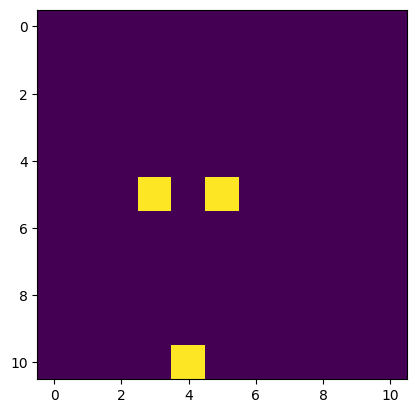

In [19]:
plt.imshow(obs[0])

In [7]:
obs

array([[ 1.0000000e+00,  1.0000000e+00,  7.5000000e-01,  3.1250000e-01,
         0.0000000e+00],
       [ 1.0000000e+00,  2.5663972e-02, -5.0143999e-01, -7.1211636e-02,
         8.3314424e-04],
       [ 1.0000000e+00,  1.6419359e-01, -7.5000000e-01, -5.4853592e-02,
         0.0000000e+00],
       [ 1.0000000e+00,  2.2710910e-01, -2.5214577e-01, -6.9980927e-02,
         1.2502493e-03],
       [ 1.0000000e+00,  3.6740473e-01, -5.0000000e-01, -6.2814780e-02,
         0.0000000e+00]], dtype=float32)

In [2]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 16.7 MB/s eta 0:00:00 MB/s eta 0:00:01:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 14.9 MB/s eta 0:00:00
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
